In [58]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
import empyrical

In [2]:
tickers = ["GE", "PFE","SBUX"]
stocks = pd.concat([yf.Ticker(i).history(period = "max")["Close"].pct_change().dropna().rename(i) for i in tickers], axis=1, join = 'inner')

In [16]:
def get_weights(r0, mean, std, covar):
   
    #mean = [i.mean() for i in stocks]
    #std = [i.std() for i in stocks]
    
    n = len(mean)
    mean = mean.values.reshape((n,1))
    #np.matmul(covar_inverse, covar)

    ones_column = np.ones((n, 1))
    mu_matrix = np.hstack((mean, ones_column))

    returns_matrix = np.vstack((r0,np.array([[1]]))) 

    A = np.zeros((2, 2))
    A[0,0] = np.matmul(np.transpose(mean), np.linalg.solve(covar.values, mean))
    A[0,1] = np.matmul(np.transpose(mean), np.linalg.solve(covar.values, ones_column))
    A[1,0] = np.matmul(np.transpose(mean), np.linalg.solve(covar.values, ones_column))
    A[1,1] = np.matmul(np.transpose(ones_column), np.linalg.solve(covar.values, ones_column))

    return np.linalg.solve(covar.values, np.matmul(mu_matrix, np.linalg.solve(A, returns_matrix)))
    

In [67]:
X = stocks.resample("7d").mean()
dates = X.index[1:-1]
portfolio = pd.DataFrame()
for day in dates[:-1]:
    sample = stocks[day:day+pd.offsets.DateOffset(days = 6)]
    mean = sample.mean(axis=0)
    r0 = mean.mean()
    std = sample.std(axis=0)
    covar = sample.cov()
    weights_vector = get_weights(r0, mean, std, covar)
    portfolio = pd.concat([stocks[day+pd.offsets.DateOffset(days = 7):day+pd.offsets.DateOffset(days=13)].dot(weights_vector), portfolio])
portfolio = portfolio.sort_index()


C:\Users\innsu\anaconda3\lib\site-packages\pandas\core\frame.py:7605: RuntimeWarning: Degrees of freedom <= 0 for slice
  baseCov = np.cov(mat.T)
C:\Users\innsu\anaconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
C:\Users\innsu\anaconda3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


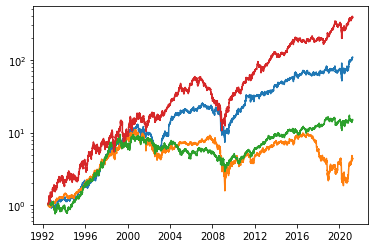

In [68]:

plt.plot((1+portfolio).cumprod())
plt.plot((1+stocks).cumprod())
plt.yscale("log")


In [72]:
empyrical.sharpe_ratio(stocks)

array([0.3214393 , 0.48821012, 0.73268087])

In [73]:
empyrical.sharpe_ratio(portfolio.sort_index())


array([0.69897587])

In [35]:


dates[0]


,GE,PFE,SBUX
Date,,,
1992-07-06,0.001618,0.016584,0.000000
1992-07-07,-0.016155,-0.008157,0.000000
1992-07-08,0.011494,0.006579,-0.021979
1992-07-09,0.009741,0.011438,0.033708
1992-07-10,-0.017685,0.000000,0.010869
